In [9]:
import os
import json
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
warnings.filterwarnings('ignore')

In [10]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Hyperparameters
learning_rate = 0.001
batch_size = 128
num_epochs = 50

In [11]:
# Load data
with open('/home/chaimaa.abi/Desktop/AI_project/all_1233_7.json', 'r') as f:
    data = json.load(f)
 
df = pd.DataFrame(data)
 
y = df['caption']
X = df['image']
 
# Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
 
for train_index, test_index in sss.split(X, y):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]
 
# Split train data into validation set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
 
for train_index, val_index in sss.split(train_data['image'], train_data['caption']):
    train_data_split = train_data.iloc[train_index]
    val_data = train_data.iloc[val_index]
 
# Encode labels
label_encoder = LabelEncoder()
train_data_split['label'] = label_encoder.fit_transform(train_data_split['caption'])
val_data['label'] = label_encoder.transform(val_data['caption'])
test_data['label'] = label_encoder.transform(test_data['caption'])
 
# Split image paths and labels
train_image_paths, train_labels = train_data_split['image'].to_numpy(), train_data_split['label'].to_numpy()
val_image_paths, val_labels = val_data['image'].to_numpy(), val_data['label'].to_numpy()
test_image_paths, test_labels = test_data['image'].to_numpy(), test_data['label'].to_numpy()

In [12]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        return len(self.image_paths)
 
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
 
        img = Image.open(image_path).convert('RGB')
 
        if self.transform:
            img = self.transform(img)
 
        return img, label

In [13]:
# Define transformsdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
# Create Datasets and DataLoaders
train_dataset = CustomDataset(train_image_paths, train_labels, transform=data_transform)
val_dataset = CustomDataset(val_image_paths, val_labels, transform=data_transform)
 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [15]:
# Create ResNet50 model with pre-trained weights (excluding the top layer)
model = models.resnet50(pretrained=True)
num_classes = len(set(train_data_split['caption']))
model.fc = nn.Linear(model.fc.in_features, num_classes)
 
# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False
 
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)

In [16]:
# Configure logging
log_file = '/home/chaimaa.abi/Desktop/AI_project/checkpoints/training_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')

best_epoch = -1
 
for epoch in range(num_epochs):

    model.train()

    total_train_loss = 0.0

    correct_train = 0

    total_train = 0
 
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):

        images, labels = images.to(device), labels.to(device)
 
        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
 
        total_train_loss += loss.item()

        _, predicted = outputs.max(1)

        total_train += labels.size(0)

        correct_train += predicted.eq(labels).sum().item()
 
    average_train_loss = total_train_loss / len(train_loader)

    train_accuracy = correct_train / total_train
 
    model.eval()

    total_val_loss = 0.0

    correct_val = 0

    total_val = 0
 
    with torch.no_grad():

        for images, labels in tqdm(val_loader, desc='Validation', leave=False):

            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
 
            _, predicted = outputs.max(1)

            total_val += labels.size(0)

            correct_val += predicted.eq(labels).sum().item()
 
    average_val_loss = total_val_loss / len(val_loader)

    val_accuracy = correct_val / total_val
 
    # Check if the current validation loss is the best so far

    if average_val_loss < best_val_loss:

        best_val_loss = average_val_loss

        best_epoch = epoch
 
        # Save the model checkpoint

        torch.save(model.state_dict(), '/home/chaimaa.abi/Desktop/AI_project/checkpoints/best_model.pth')
 
    # Append values for plotting

    train_losses.append(average_train_loss)

    val_losses.append(average_val_loss)

    train_accuracies.append(train_accuracy)

    val_accuracies.append(val_accuracy)
 
    # Log training progress

    logging.info(f'Epoch [{epoch + 1}/{num_epochs}], '

                 f'Training Loss: {average_train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%, '

                 f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '

                 f'Training Loss: {average_train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%, '

                 f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}')
    
print(f'Best model achieved at epoch {best_epoch + 1} with validation loss: {best_val_loss:.4f}')

logging.info(f'Best model achieved at epoch {best_epoch + 1} with validation loss: {best_val_loss:.4f}')
 
# Close the logging file handler

logging.shutdown()


Epoch [1/50], Training Loss: 5.5986, Training Accuracy: 16.23%, Validation Loss: 4.5399, Validation Accuracy: 23.44


Epoch [2/50], Training Loss: 3.6151, Training Accuracy: 31.44%, Validation Loss: 4.1599, Validation Accuracy: 27.13


Epoch [3/50], Training Loss: 2.8503, Training Accuracy: 40.98%, Validation Loss: 3.9908, Validation Accuracy: 28.51


Epoch [4/50], Training Loss: 2.3659, Training Accuracy: 48.48%, Validation Loss: 3.9409, Validation Accuracy: 29.31


Epoch [5/50], Training Loss: 2.0445, Training Accuracy: 54.14%, Validation Loss: 3.9418, Validation Accuracy: 30.13


Epoch [6/50], Training Loss: 1.7982, Training Accuracy: 59.14%, Validation Loss: 3.9415, Validation Accuracy: 30.46


Epoch [7/50], Training Loss: 1.6036, Training Accuracy: 63.21%, Validation Loss: 3.9974, Validation Accuracy: 29.94


Epoch [8/50], Training Loss: 1.4574, Training Accuracy: 66.55%, Validation Loss: 3.9824, Validation Accuracy: 30.83


Epoch [9/50], Training Loss: 1.3352, Training Accuracy: 69.33%, Validation Loss: 4.0037, Validation Accuracy: 30.17


Epoch [10/50], Training Loss: 1.2219, Training Accuracy: 71.93%, Validation Loss: 3.9889, Validation Accuracy: 31.23


Epoch [11/50], Training Loss: 1.1354, Training Accuracy: 74.04%, Validation Loss: 4.1047, Validation Accuracy: 30.12


Epoch [12/50], Training Loss: 1.0634, Training Accuracy: 75.93%, Validation Loss: 4.1110, Validation Accuracy: 30.86


Epoch [13/50], Training Loss: 1.0108, Training Accuracy: 77.27%, Validation Loss: 4.0792, Validation Accuracy: 31.20


Epoch [14/50], Training Loss: 0.9575, Training Accuracy: 78.54%, Validation Loss: 4.1124, Validation Accuracy: 31.28


Epoch [15/50], Training Loss: 0.9058, Training Accuracy: 79.80%, Validation Loss: 4.1422, Validation Accuracy: 30.80


Epoch [16/50], Training Loss: 0.8764, Training Accuracy: 80.72%, Validation Loss: 4.1701, Validation Accuracy: 30.55


Epoch [17/50], Training Loss: 0.8374, Training Accuracy: 81.48%, Validation Loss: 4.1949, Validation Accuracy: 31.01


Epoch [18/50], Training Loss: 0.8063, Training Accuracy: 82.29%, Validation Loss: 4.2048, Validation Accuracy: 30.89


Epoch [19/50], Training Loss: 0.7666, Training Accuracy: 83.53%, Validation Loss: 4.2068, Validation Accuracy: 31.05


Epoch [20/50], Training Loss: 0.7497, Training Accuracy: 83.97%, Validation Loss: 4.2228, Validation Accuracy: 30.67


Epoch [21/50], Training Loss: 0.7267, Training Accuracy: 84.66%, Validation Loss: 4.2348, Validation Accuracy: 31.20


Epoch [22/50], Training Loss: 0.7087, Training Accuracy: 85.15%, Validation Loss: 4.2701, Validation Accuracy: 30.71


Epoch [23/50], Training Loss: 0.6941, Training Accuracy: 85.36%, Validation Loss: 4.3030, Validation Accuracy: 30.83


Epoch [24/50], Training Loss: 0.6705, Training Accuracy: 86.14%, Validation Loss: 4.3058, Validation Accuracy: 30.60


Epoch [25/50], Training Loss: 0.6710, Training Accuracy: 85.78%, Validation Loss: 4.3037, Validation Accuracy: 30.81


Epoch [26/50], Training Loss: 0.6428, Training Accuracy: 86.89%, Validation Loss: 4.3033, Validation Accuracy: 30.62


Epoch [27/50], Training Loss: 0.6264, Training Accuracy: 87.20%, Validation Loss: 4.3936, Validation Accuracy: 29.81


Epoch [28/50], Training Loss: 0.6230, Training Accuracy: 87.19%, Validation Loss: 4.3288, Validation Accuracy: 30.42


Epoch [29/50], Training Loss: 0.6162, Training Accuracy: 87.53%, Validation Loss: 4.3400, Validation Accuracy: 30.95


Epoch [30/50], Training Loss: 0.6013, Training Accuracy: 87.93%, Validation Loss: 4.3233, Validation Accuracy: 30.85


Epoch [31/50], Training Loss: 0.5805, Training Accuracy: 88.53%, Validation Loss: 4.3266, Validation Accuracy: 31.05


Epoch [32/50], Training Loss: 0.5733, Training Accuracy: 88.86%, Validation Loss: 4.2798, Validation Accuracy: 31.17


Epoch [33/50], Training Loss: 0.5686, Training Accuracy: 88.93%, Validation Loss: 4.3564, Validation Accuracy: 30.77


Epoch [34/50], Training Loss: 0.5604, Training Accuracy: 89.14%, Validation Loss: 4.3579, Validation Accuracy: 30.41


Epoch [35/50], Training Loss: 0.5517, Training Accuracy: 89.59%, Validation Loss: 4.3579, Validation Accuracy: 30.46


Epoch [36/50], Training Loss: 0.5570, Training Accuracy: 89.24%, Validation Loss: 4.3775, Validation Accuracy: 30.69


Epoch [37/50], Training Loss: 0.5399, Training Accuracy: 89.79%, Validation Loss: 4.3872, Validation Accuracy: 30.80


Epoch [38/50], Training Loss: 0.5400, Training Accuracy: 89.71%, Validation Loss: 4.3426, Validation Accuracy: 30.95


Epoch [39/50], Training Loss: 0.5267, Training Accuracy: 90.11%, Validation Loss: 4.3783, Validation Accuracy: 30.67


Epoch [40/50], Training Loss: 0.5241, Training Accuracy: 90.34%, Validation Loss: 4.3147, Validation Accuracy: 31.34


Epoch [41/50], Training Loss: 0.5162, Training Accuracy: 90.44%, Validation Loss: 4.3334, Validation Accuracy: 31.08


Epoch [42/50], Training Loss: 0.5171, Training Accuracy: 90.48%, Validation Loss: 4.3610, Validation Accuracy: 31.05


Epoch [43/50], Training Loss: 0.5099, Training Accuracy: 90.67%, Validation Loss: 4.3939, Validation Accuracy: 30.41


Epoch [44/50], Training Loss: 0.5157, Training Accuracy: 90.31%, Validation Loss: 4.3495, Validation Accuracy: 30.91


Epoch [45/50], Training Loss: 0.5043, Training Accuracy: 90.59%, Validation Loss: 4.3273, Validation Accuracy: 30.85


Epoch [46/50], Training Loss: 0.4960, Training Accuracy: 90.94%, Validation Loss: 4.3594, Validation Accuracy: 31.27


Epoch [47/50], Training Loss: 0.5017, Training Accuracy: 90.91%, Validation Loss: 4.3293, Validation Accuracy: 31.06


Epoch [48/50], Training Loss: 0.4930, Training Accuracy: 91.07%, Validation Loss: 4.3987, Validation Accuracy: 30.65


Epoch [49/50], Training Loss: 0.4874, Training Accuracy: 91.31%, Validation Loss: 4.3729, Validation Accuracy: 31.67


Epoch [50/50], Training Loss: 0.4880, Training Accuracy: 91.14%, Validation Loss: 4.3935, Validation Accuracy: 31.05
Best model achieved at epoch 4 with validation loss: 3.9409


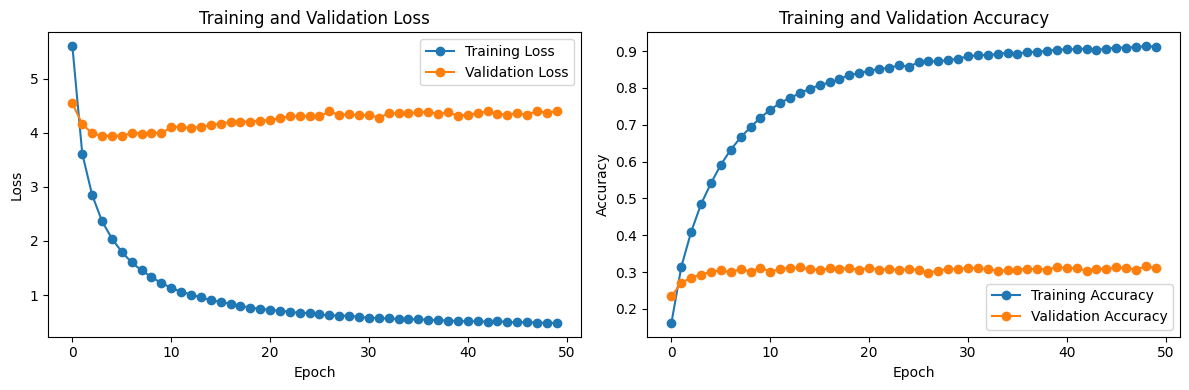

In [17]:
# Plotting
plt.figure(figsize=(12, 4))
 
# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
 
# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
 
plt.tight_layout()
plt.savefig('/home/chaimaa.abi/Desktop/AI_project/figures/history_1233.png')
plt.show()

In [18]:
# Load the best model checkpoint
best_model_path = '/home/chaimaa.abi/Desktop/AI_project/checkpoints/best_model.pth'
best_model = models.resnet50(pretrained=False)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

# Create a DataLoader for the test set
test_dataset = CustomDataset(test_image_paths, test_labels, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the best model on the test set
total_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

average_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%')


Test Loss: 3.9389, Test Accuracy: 28.88%
